In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.stats import LombScargle
import astropy.convolution as cv
from astropy.io import fits
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
fstep = 0.2
freq = np.arange(min(full_freq), max(full_freq), fstep)
itrp_power = np.interp(freq, full_freq, power)
smoothed_power = cv.convolve(itrp_power, cv.Box1DKernel(6 / fstep))

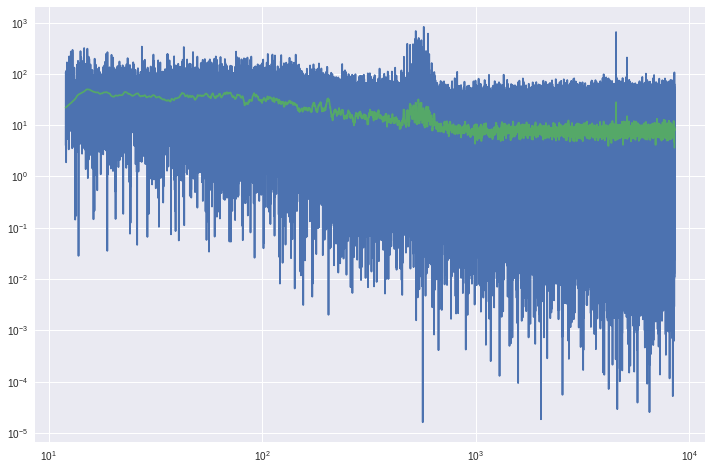

In [5]:
plt.loglog(full_freq, power)
plt.loglog(freq, smoothed_power);

In [12]:
v_nyq = 8496.36
with pm.Model() as max_model:
    W = pm.Bound(pm.Normal, lower=0)('W', mu=12, sd=1)
    R_v = (pm.math.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
    k=3
    a = pm.Normal('a', mu=np.array([59, 67, 76]).reshape(k,1), sd=8, shape=(k,1))
    
    b = pm.Normal('b', mu=np.array([5, 150, 400]).reshape(k,1), sd=np.array([1, 32, 64]).reshape(k,1), shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4), axis=0)
    
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=18, sd=3)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=568, sd=8)
    
    s = pm.HalfCauchy('s', 55)
    
    envelope = pm.Normal.dist(mu=v_max, sd=s).logp(freq)
    e = pm.HalfCauchy('e', 1)
    like = W + R_v * (harv + H0 * pm.math.exp(-(freq - v_max)**2) / (2 * s**2))
#     like = W + R_v * (harv + H0 * pm.math.exp(envelope))
    y = pm.Normal('obs', mu=like, sd=e, observed=smoothed_power)
    

In [13]:
with max_model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, s_log__, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
100%|██████████| 3000/3000 [11:36<00:00,  4.31it/s]
The acceptance probability does not match the target. It is 0.8847437464962993, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967656818256808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836492543850076, but should be close to 0.8. Try to increase the number of tuning steps.
The accep

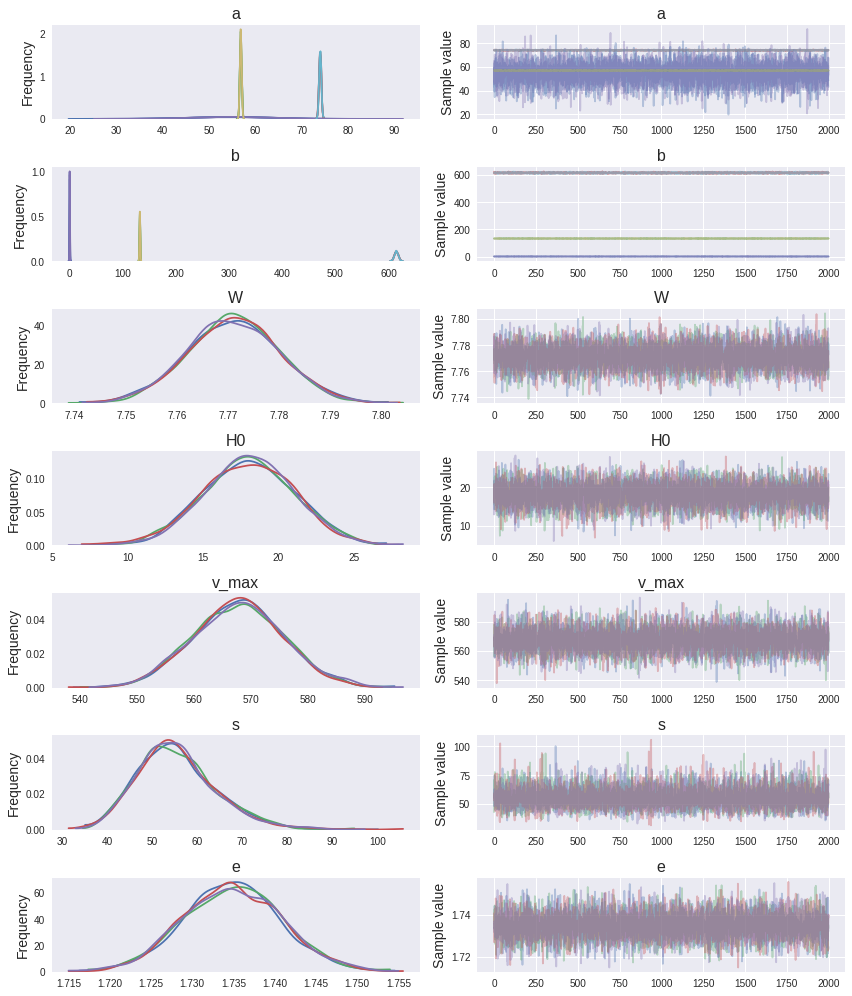

In [18]:
pm.traceplot(trace);

In [14]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0_0,54.333202,8.564833,0.103381,37.894489,71.055229,6594.0,1.000007
a__1_0,56.929380,0.201269,0.003370,56.517560,57.310858,5206.0,1.007489
a__2_0,73.732415,0.255655,0.008311,73.226427,74.213215,16.0,1.063717
b__0_0,1.347648,0.427220,0.005240,0.484368,2.158083,5930.0,0.999960
b__1_0,133.333520,0.753728,0.010984,131.837173,134.807512,5990.0,1.003327
b__2_0,612.480510,3.632093,0.069643,605.451174,619.758808,111.0,1.016869
W,7.771922,0.009167,0.000102,7.753669,7.789279,8000.0,1.000917
H0,18.241470,3.006412,0.043567,12.628927,24.500239,5249.0,0.999913
v_max,564.542938,6.266489,0.626570,553.562762,568.351353,2.0,72.495206
s,0.851559,0.120215,0.009314,0.619809,1.059459,3.0,1.713250


In [15]:
ppc = pm.sample_ppc(trace, 1000, max_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:06<00:00, 159.03it/s]


In [16]:
def harvey(v, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)

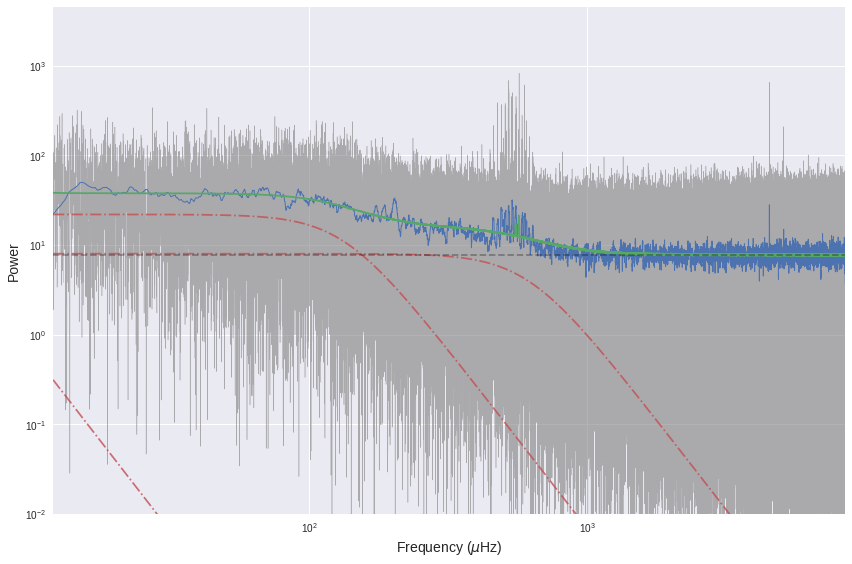

In [17]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5')
plt.loglog(freq, smoothed_power, 'C0', lw=1)
plt.loglog(freq, post, 'C1')
# plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace['a'].mean(axis=0)
b = trace['b'].mean(axis=0)
[plt.loglog(freq, harv, 'C2-.', alpha=.8) for harv in harvey(freq, a, b)]
plt.axhline(trace['W'].mean(), c='k', alpha=.3, ls='--')
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout();

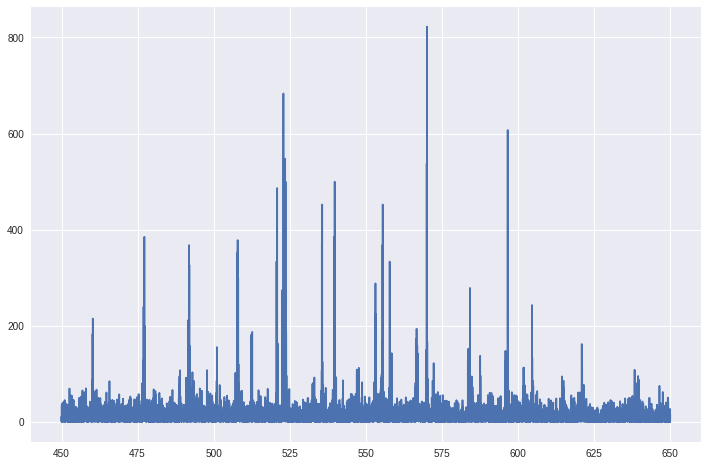

In [18]:
mask = (full_freq > 450) & (full_freq < 650)
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(subfreq, subpower)

In [19]:
modes = np.array([460, 492, 523, 555, 587, 457, 488, 520, 553, 584, 501, 535, 570, 604, 640, 497, 532, 566, 600, 636])
n = len(modes)
with pm.Model() as mode_model:
    A = pm.Normal('A', mu=20, sd=10, shape=(n,1))
    v0 = pm.Normal('v0', mu=modes.reshape(n,1), sd=10, shape=(n,1))
    L = pm.Bound(pm.Normal, lower=0)('L', mu=0.2, sd=1, shape=(n,1))
    R_v = (pm.math.sin( np.pi * subfreq / (2 * v_nyq)) / ((np.pi * subfreq) / (2 * v_nyq)))**2
    
    e = pm.HalfCauchy('e', 10)
    
    like = R_v * (A**2 / (np.pi * L)) / (1 + 4 * ( subfreq - v0)**2 / L**2) + trace['W'].mean()
#     like = R_v * A**2 * pm.math.exp(pm.Cauchy.dist(v0, L).logp(subfreq))
    
    y = pm.Normal('obs', mu=like, sd=e, observed=subpower)

In [20]:
with mode_model:
    mode_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, L_lowerbound__, v0, A]
100%|██████████| 1500/1500 [1:16:07<00:00,  3.04s/it]
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9718039728549176, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9720172512586048, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree

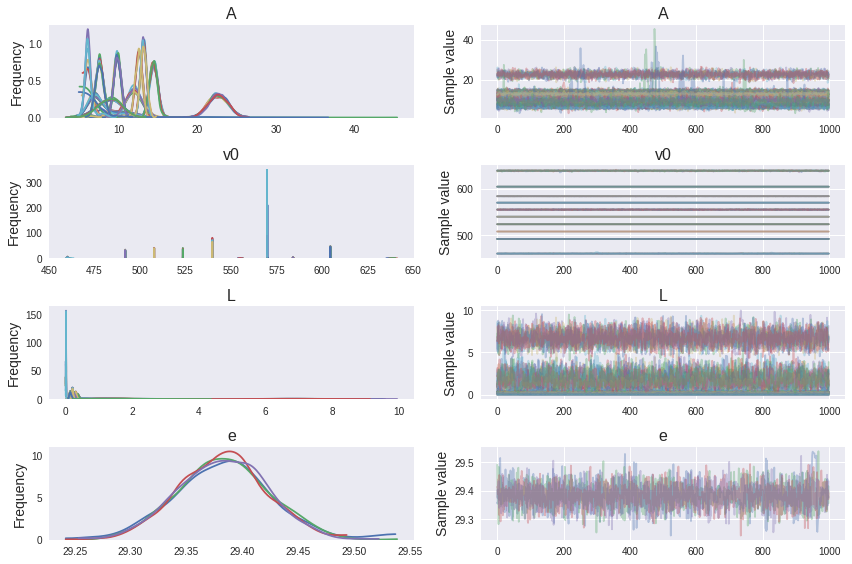

In [22]:
pm.traceplot(mode_trace);

In [23]:
prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:13<00:00, 72.94it/s]


[[<matplotlib.lines.Line2D at 0x7fbc4e10db38>],

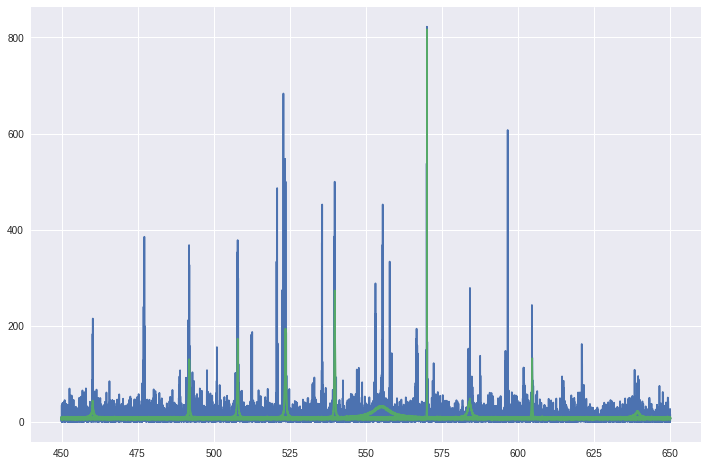

In [25]:
plt.plot(subfreq, subpower)
[plt.plot(subfreq, fit, 'C1') for fit in prof]